<a href="https://colab.research.google.com/github/shreyas1209/Emotion-Detection/blob/main/Emotion_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#testing data preprocessing
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import PIL
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
from torchvision import datasets
from torchvision import transforms
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader, TensorDataset
from numpy import genfromtxt
import torchvision.utils as vutils
import cv2

In [2]:

#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Using pandas to see how the train and validation data is stored in the csv file


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Emotion Detector/emotion_detection/icml_face_data.csv')
df


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [5]:
emotion_dict = {0 :'Angry' ,1 :'Disgusted' , 2 :'Fear' ,3 : 'Happy' ,4 :'Sad' ,5 :'Surprise' ,6 : 'Neutral' }

Exploratory Data Analysis

In [6]:
train_num_counts = np.zeros(7)
val_num_counts = np.zeros(7)
for i in range(7):
  train_num_counts[i] = df['emotion'][(df['emotion']==i) &(df[' Usage'] == 'Training')].value_counts()
  val_num_counts[i] = df['emotion'][(df['emotion']==i) &(df[' Usage'] == 'PrivateTest')].value_counts()
print(train_num_counts,val_num_counts)

[3995.  436. 4097. 7215. 4830. 3171. 4965.] [491.  55. 528. 879. 594. 416. 626.]


Plotting the bar graph for training data

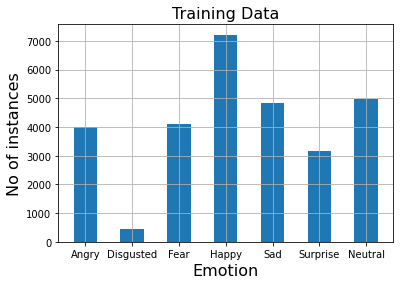

In [7]:

plt.bar(emotion_dict.values(),train_num_counts,width = 0.5)
plt.xlabel('Emotion',fontdict={'size': 16})
plt.ylabel('No of instances',fontdict={'size': 16})
plt.title("Training Data",fontdict={'size': 16})
plt.grid()
plt.show()


The number of data items belonging to the class 'Disgusted' is quite low compared to the other classes

Plotting the graph for validation data

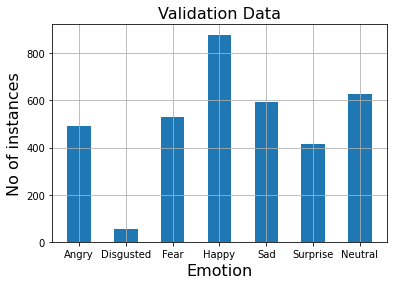

In [8]:
plt.bar(emotion_dict.values(),val_num_counts,width = 0.5)
plt.xlabel('Emotion',fontdict={'size': 16})
plt.ylabel('No of instances',fontdict={'size': 16})
plt.title("Validation Data",fontdict={'size': 16})
plt.grid()

plt.show()

function that converts string data to tensor

In [9]:
def totensor(dataval):
  data = dataval.split()
  data = [int(i) for i in data]
  data = torch.tensor(data, dtype = torch.float)
  return data




    
    


In [10]:
def DATASET (df,normalize = 'False'):
  data = df[' pixels']
  data = [totensor(i) for i in data]
  data = torch.stack([image for image in data])
  data = (data.reshape(data.shape[0],1,48,48)/256)
  if normalize == 'True':
    datastack = torch.stack([data[i] for i in range(len(data))],dim= 2)
    mean = datastack.view(1,-1).mean(dim = 1)
    std = datastack.view(1,-1).std(dim = 1)
    print(mean, std)
    data = ((data-mean)/std)
    

  labels = torch.tensor(df['emotion'].to_numpy())
  dataset = TensorDataset(data, labels)
  return dataset










In [11]:
train_dataset = DATASET(df[df[' Usage']=='Training'],normalize = 'True')
val_dataset = DATASET(df[df[' Usage']=='PrivateTest'])
test_dataset = DATASET(df[df[' Usage']=='PublicTest'])

tensor([0.5058]) tensor([0.2540])


tensor([[[-0.9146, -0.7608, -0.7301,  ..., -1.1914, -1.3298, -1.3606],
         [-0.9915, -1.0530, -1.0991,  ..., -1.1299, -1.1914, -1.3144],
         [-1.2222, -1.3298, -1.1607,  ..., -1.2375, -1.1299, -1.2683],
         ...,
         [-0.5917, -0.9915, -1.3452,  ..., -0.8838, -1.1299, -1.3298],
         [-0.8070, -0.7301, -0.7762,  ..., -0.3764, -0.9146, -1.2837],
         [-0.8070, -0.8838, -0.6993,  ..., -0.3610, -0.3149, -0.7301]]])


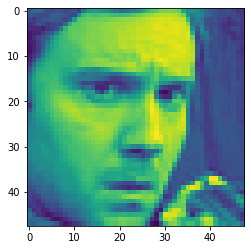

In [12]:
print(train_dataset[0][0])
plt.imshow(train_dataset[0][0].reshape(48,48))


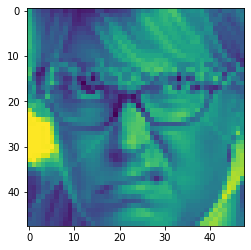

In [13]:
val_dataset[0][0]
plt.imshow(val_dataset[0][0].reshape(48,48))

tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.0625, 0.0000, 0.6289],
         [0.9922, 0.9922, 0.9922,  ..., 0.0664, 0.0000, 0.4766],
         [0.9922, 0.9922, 0.9922,  ..., 0.1016, 0.0000, 0.4453],
         ...,
         [0.2578, 0.3359, 0.3867,  ..., 0.9961, 0.9844, 0.9922],
         [0.3281, 0.3594, 0.3594,  ..., 0.9219, 0.9961, 0.9961],
         [0.3633, 0.3516, 0.3320,  ..., 0.1641, 0.5039, 0.7031]]])


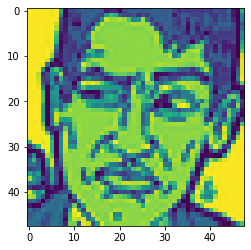

In [14]:
print(test_dataset[0][0])
plt.imshow(test_dataset[0][0].reshape(48,48))

In [15]:
batch_size = 128

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)


Importing the training and models module

In [17]:
import sys

sys.path.append('/content/gdrive/MyDrive/Emotion Detector') 


In [18]:
from Emotion_train import *
from Emotion_models import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
model = emonet(7)
learning_rate = 1e-3
epochs = 50
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()




    
    

    

In [ ]:
start = time.process_time()
model,history = train(train_dataloader,val_dataloader,epochs,model,loss_func,optimizer)
end = time.process_time()
elapsed = end-start
print("Total time :", elapsed)

Post training analysis

In [ ]:
epoch_no = [(i+1) for i in range(epochs)]

plt.plot(epoch_no,history["train_accuracy"], label = 'Train Accuracies')
plt.plot(epoch_no,history["val_accuracy"], label = 'Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title('Accuracy')
plt.legend()
plt.show()





In [ ]:
plt.plot(epoch_no,history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss')
plt.show()


In [ ]:
plt.plot(epoch_no,history["lr"])
plt.xlabel("Epochs")
plt.ylabel("Learning Rates")
plt.title('Learnrng rates')
plt.show()


In [ ]:
test_score = check_accuracy(test_dataloader,model)
print("Test dataset score :",test_score)
